In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import torch
import sys
import time
from models import UNet
from dataloader import get_dataloaders

In [21]:
for i in range(5):
    # set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    timings = {}
    in_len = 5
    out_len = 1
    
    # Data preparation
    torch.cuda.synchronize() 
    data_prep_start = time.time()
    test_loader, _ = get_dataloaders(1,
                                in_len=in_len,
                                out_len=out_len,
                                )
    
    test_input, test_target = next(iter(test_loader))
    test_input, test_target = test_input.to(device), test_target.to(device).float()
    torch.cuda.synchronize()
    data_prep_end = time.time()
    timings['data_preparation'] = data_prep_end - data_prep_start
    
    # Model load 
    torch.cuda.synchronize() 
    start_time = time.time()
    with torch.no_grad():
        model = torch.jit.load('./checkpoint/unet_d5_out1_gpu_L1_traced.pt', map_location="cuda")
        model.eval()
        torch.cuda.synchronize() 
        model_prep_end = time.time()
        timings['model_load'] = model_prep_end - start_time
    
    # Warm up
    with torch.no_grad():
        for k in range(10):
            _ = model(test_input)
    
    # Inference
    num_runs = 100 
    inference_times = []
    
    for j in range(num_runs):
        torch.cuda.synchronize() 
        start_inference = time.time()
        
        with torch.no_grad():
            test_output = model(test_input)
        
        torch.cuda.synchronize()
        end_inference = time.time()
        inference_times.append(end_inference - start_inference)

    print(inference_times)
    avg_inference = sum(inference_times) / num_runs
    std_inference = (sum((x - avg_inference) ** 2 for x in inference_times) / num_runs) ** 0.5
    timings['avg_inference'] = avg_inference
    timings['std_inference'] = std_inference
    
    print("\n=== Result ===")
    print(f"device: {device}")
    print(f"Data preparation time: {timings['data_preparation']:.6f} sec")
    print(f"Model load time: {timings['model_load']:.6f} sec")
    print(f"Average inference ({num_runs} runs): {avg_inference:.6f} sec")
    
    batch_size = test_input.size(0)
    throughput = batch_size / avg_inference
    print(f"Throughput: {throughput:.2f} samples/sec")

Using device: cuda
[0.002073049545288086, 0.0020360946655273438, 0.002044677734375, 0.002034902572631836, 0.0020503997802734375, 0.002040386199951172, 0.002044200897216797, 0.0020356178283691406, 0.0020465850830078125, 0.002042055130004883, 0.0020444393157958984, 0.002050638198852539, 0.0020492076873779297, 0.002039670944213867, 0.002043485641479492, 0.002044677734375, 0.002044677734375, 0.0020360946655273438, 0.0020172595977783203, 0.0020046234130859375, 0.0020122528076171875, 0.002007722854614258, 0.002004861831665039, 0.002013683319091797, 0.002008676528930664, 0.0020046234130859375, 0.0020189285278320312, 0.0020072460174560547, 0.0020134449005126953, 0.0020084381103515625, 0.002016782760620117, 0.002019643783569336, 0.002112865447998047, 0.002013683319091797, 0.0020127296447753906, 0.0020093917846679688, 0.0020117759704589844, 0.0020093917846679688, 0.002022981643676758, 0.0020170211791992188, 0.0020177364349365234, 0.0020112991333007812, 0.0020170211791992188, 0.002008438110351562

In [4]:
for i in range(5):
    # set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    timings = {}
    in_len = 5
    out_len = 1
    
    # Data preparation
    torch.cuda.synchronize() 
    data_prep_start = time.time()
    test_input = np.fromfile("data/input_tensor.dat", dtype=np.float32)
    input_shape = (320, 320, in_len, out_len)
    test_input = test_input.reshape(input_shape)
    test_input = test_input.transpose()
    test_target = np.fromfile("data/target_tensor.dat", dtype=np.float32)
    target_shape = (320, 320, 1, 1)
    test_target = test_target.reshape(target_shape)
    test_target = test_target.transpose()

    test_input, test_target = torch.from_numpy(test_input), torch.from_numpy(test_target) 
    test_input, test_target = test_input.to(device), test_target.to(device).float()
    torch.cuda.synchronize()
    data_prep_end = time.time()
    timings['data_preparation'] = data_prep_end - data_prep_start
       
    print("\n=== Result ===")
    print(f"device: {device}")
    print(f"Data preparation time: {timings['data_preparation']:.6f} sec")

Using device: cuda

=== Result ===
device: cuda
Data preparation time: 0.001943 sec
Using device: cuda

=== Result ===
device: cuda
Data preparation time: 0.001323 sec
Using device: cuda

=== Result ===
device: cuda
Data preparation time: 0.001201 sec
Using device: cuda

=== Result ===
device: cuda
Data preparation time: 0.001141 sec
Using device: cuda

=== Result ===
device: cuda
Data preparation time: 0.001285 sec


In [69]:
for i in range(5):
    # set the device
    device = torch.device('cpu')
    print(f"Using device: {device}")
    
    timings = {}
    in_len = 5
    out_len = 1
    
    # Data preparation
    data_prep_start = time.time()
    test_loader, _ = get_dataloaders(1,
                                in_len=in_len,
                                out_len=out_len,
                                )
    
    test_input, test_target = next(iter(test_loader))
    test_input, test_target = test_input.to(device), test_target.to(device).float()
    data_prep_end = time.time()
    timings['data_preparation'] = data_prep_end - data_prep_start
    
    # Model load
    start_time = time.time()
    with torch.no_grad():
        model = torch.jit.load('./checkpoint/unet_d5_out1_gpu_L1_traced.pt', map_location="cpu")
        model.eval()
        model_prep_end = time.time()
        timings['model_load'] = model_prep_end - start_time
    
    # Warm up
    with torch.no_grad():
        for k in range(10):
            _ = model(test_input)
    
    # Inference
    num_runs = 100 
    inference_times = []
    
    for i in range(num_runs):
        start_inference = time.time()
        
        with torch.no_grad():
            test_output = model(test_input)
        
        end_inference = time.time()
        inference_times.append(end_inference - start_inference)

    print(inference_times)
    avg_inference = sum(inference_times) / num_runs
    std_inference = (sum((x - avg_inference) ** 2 for x in inference_times) / num_runs) ** 0.5
    timings['avg_inference'] = avg_inference
    timings['std_inference'] = std_inference
    
    print("\n=== Result ===")
    print(f"device: {device}")
    print(f"Data preparation time: {timings['data_preparation']:.6f} sec")
    print(f"Model load time: {timings['model_load']:.6f} sec")
    print(f"Average inference ({num_runs} runs): {avg_inference:.6f} sec")
    
    batch_size = test_input.size(0)
    throughput = batch_size / avg_inference
    print(f"Throughput: {throughput:.2f} samples/sec")

Using device: cpu
[0.2104816436767578, 0.20246052742004395, 0.19814276695251465, 0.19741392135620117, 0.20060348510742188, 0.19717121124267578, 0.20287775993347168, 0.2832825183868408, 0.20086193084716797, 0.200486421585083, 0.20495271682739258, 0.19643855094909668, 0.1963028907775879, 0.19576287269592285, 0.1926584243774414, 0.20565342903137207, 0.2225937843322754, 0.2160186767578125, 0.1973710060119629, 0.19846749305725098, 0.24312257766723633, 0.19990921020507812, 0.2126319408416748, 0.19620919227600098, 0.1995680332183838, 0.20366883277893066, 0.19717788696289062, 0.27307558059692383, 0.19751858711242676, 0.27823877334594727, 0.21004581451416016, 0.2106630802154541, 0.20092034339904785, 0.21354150772094727, 0.2070307731628418, 0.21259093284606934, 0.19952893257141113, 0.21462059020996094, 0.20394301414489746, 0.19993233680725098, 0.21920514106750488, 0.19490385055541992, 0.201127290725708, 0.20035171508789062, 0.19878554344177246, 0.2048180103302002, 0.21270513534545898, 0.19418239

In [6]:
for i in range(5):
    # set the device
    device = torch.device('cpu')
    print(f"Using device: {device}")
    
    timings = {}
    in_len = 5
    out_len = 1
    
    # Data preparation
    data_prep_start = time.time()
    test_input = np.fromfile("data/input_tensor.dat", dtype=np.float32)
    input_shape = (320, 320, in_len, out_len)
    test_input = test_input.reshape(input_shape)
    test_input = test_input.transpose()
    test_target = np.fromfile("data/target_tensor.dat", dtype=np.float32)
    target_shape = (320, 320, 1, 1)
    test_target = test_target.reshape(target_shape)
    test_target = test_target.transpose()

    test_input, test_target = torch.from_numpy(test_input), torch.from_numpy(test_target) 
    test_input, test_target = test_input.to(device), test_target.to(device).float()
    data_prep_end = time.time()
    timings['data_preparation'] = data_prep_end - data_prep_start
    
    print("\n=== Result ===")
    print(f"device: {device}")
    print(f"Data preparation time: {timings['data_preparation']:.6f} sec")

Using device: cpu

=== Result ===
device: cpu
Data preparation time: 0.001605 sec
Using device: cpu

=== Result ===
device: cpu
Data preparation time: 0.001257 sec
Using device: cpu

=== Result ===
device: cpu
Data preparation time: 0.001071 sec
Using device: cpu

=== Result ===
device: cpu
Data preparation time: 0.001104 sec
Using device: cpu

=== Result ===
device: cpu
Data preparation time: 0.001147 sec


In [7]:
%%bash
nvcc -c cuda_sync.c -o cuda_sync.o -I/user-environment/env/default/include

In [19]:
%%bash
export LD_LIBRARY_PATH=/users/class171/miniconda3/envs/weather-cnn/lib:/users/class171/FTorchbin/lib64:$LD_LIBRARY_PATH
for i in {1..5}; do make run_infer_cuda MODEL=checkpoint/unet_d5_out1_gpu_L1_traced.pt DATADIR=data; done

gfortran -I/users/class171/FTorchbin/include -I/users/class171/FTorchbin/include/ftorch -I/users/class171/Project/FTorch/build/modules -o infer_fortran_cuda.x infer_fortran_cuda.f90 cuda_sync.o -L/users/class171/FTorchbin/lib64 -L/user-environment/env/default/lib64 -lftorch -lcudart


f951: Warning: Nonexistent include directory '/users/class171/Project/FTorch/build/modules' [-Wmissing-include-dirs]


LD_LIBRARY_PATH=/user-environment/env/default/lib64:$LD_LIBRARY_PATH ./infer_fortran_cuda.x checkpoint/unet_d5_out1_gpu_L1_traced.pt data


/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   2.02220189E-03   2.01189891E-03   2.00786698E-03   2.01084302E-03   2.01020297E-03   2.01020297E-03   2.02588202E-03   2.01004301E-03   2.01433105E-03   2.01103510E-03   2.00357893E-03   2.00649095E-03   1.99529203E-03   1.99829903E-03   2.00057100E-03   2.00393097E-03   2.01500207E-03   2.00293912E-03   1.99826807E-03   1.99817098E-03   1.99625106E-03   2.00553099E-03   2.00661994E-03   2.00540409E-03   1.99173996E-03   2.00303504E-03   2.00969097E-03   1.99391507E-03   2.00370699E-03   1.99625106E-03   2.00073095E-03   2.01020297E-03   1.99525896E-03   1.99862011E-03   2.00725906E-03   1.99285895E-03   2.00821902E-03   1.99807505E-03   2.00425205E-03   1.99509994E-03   1.99612300E-03   2.00965907E-03   2.00351491E-03   2.00060289E-03   1.99346803E-03   2.00293912E-03   2.00741901E-03   2.00121105E-03   1.99813908E-03   2.00146693E-03   1.99628295E-03   2.00658711E-03   2.00018706E-03   1.98809197E-03   2.00348301E-03   1.99289108E-03   2.00636289E-03   1.99724408E-03   2.00421899E

/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   2.02501891E-03   2.00761110E-03   2.00725906E-03   2.02402589E-03   2.00706697E-03   2.01151404E-03   2.00293912E-03   2.01628311E-03   2.02361005E-03   2.00860295E-03   2.00322689E-03   2.01119506E-03   2.00607511E-03   2.02063494E-03   2.01148307E-03   1.99881196E-03   2.00153096E-03   2.00844300E-03   2.02834606E-03   2.01375410E-03   2.01433105E-03   2.00761110E-03   2.00293912E-03   2.00869911E-03   1.99878006E-03   1.99269899E-03   1.99273205E-03   2.00002710E-03   1.99634698E-03   2.00028298E-03   1.99474790E-03   1.99877890E-03   1.99062005E-03   2.00514705E-03   2.00204295E-03   1.99925900E-03   2.00140290E-03   1.99977099E-03   2.00671493E-03   2.00604298E-03   1.99381891E-03   1.99772301E-03   2.01202696E-03   2.00050697E-03   1.99189992E-03   1.99935609E-03   2.00236309E-03   2.00226693E-03   2.01017107E-03   1.99820311E-03   1.99404405E-03   2.00188300E-03   1.99967506E-03   2.01263512E-03   1.99689204E-03   1.99893909E-03   1.99874700E-03   2.00351491E-03   2.00521108E

/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   2.03695404E-03   2.01324304E-03   2.01266608E-03   2.01746705E-03   2.01106700E-03   2.01609102E-03   2.01705098E-03   2.01394712E-03   2.01180298E-03   2.01241090E-03   2.01977091E-03   2.01237900E-03   2.01570708E-03   2.02021911E-03   2.01816997E-03   2.01001111E-03   2.01244210E-03   2.01615505E-03   2.01458693E-03   2.01321091E-03   2.01148307E-03   2.01189891E-03   2.01554690E-03   2.01196293E-03   2.00828305E-03   2.00601108E-03   2.00985093E-03   2.00937106E-03   2.00521201E-03   2.00581900E-03   2.01836205E-03   2.02002702E-03   2.00943509E-03   2.01173802E-03   2.00885907E-03   2.01781793E-03   2.00921111E-03   1.96642801E-03   1.95942097E-03   1.95935695E-03   1.96678098E-03   1.96572393E-03   1.96838100E-03   1.96284405E-03   1.96962897E-03   1.96374091E-03   1.96345197E-03   1.95807707E-03   1.96892396E-03   1.96502008E-03   1.97001197E-03   1.96300494E-03   1.96802802E-03   1.97375589E-03   1.95871689E-03   1.95977208E-03   1.97362807E-03   1.96665293E-03   1.96898798E

/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   2.04066606E-03   2.04988103E-03   2.02937098E-03   2.02626688E-03   2.03596195E-03   2.01644306E-03   2.00741994E-03   1.99509994E-03   2.00114702E-03   2.00348301E-03   2.00652308E-03   2.01881095E-03   2.00642692E-03   2.00338708E-03   2.00399500E-03   2.01109890E-03   2.00921111E-03   2.00965791E-03   2.00629910E-03   2.00044294E-03   2.00025109E-03   2.01385096E-03   2.00137100E-03   1.99618703E-03   2.00255611E-03   2.00777105E-03   2.01039505E-03   2.00725906E-03   2.00473191E-03   2.00245995E-03   2.00143503E-03   2.01221812E-03   2.00498709E-03   1.99282798E-03   2.00953102E-03   2.00658711E-03   2.01676297E-03   2.00111489E-03   2.01372290E-03   2.00057100E-03   2.00434704E-03   2.01375503E-03   2.00530700E-03   2.00105109E-03   2.00770702E-03   2.00258708E-03   2.00901902E-03   2.00540293E-03   1.99913094E-03   2.01474689E-03   2.00562691E-03   2.00978690E-03   1.99983502E-03   2.01016990E-03   2.00079498E-03   2.00527511E-03   2.01148307E-03   2.00274703E-03   2.00018706E

/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   2.04184907E-03   2.02300306E-03   2.01685890E-03   2.02508294E-03   2.02639401E-03   2.02213903E-03   2.02367408E-03   2.02181889E-03   2.01999396E-03   2.01663491E-03   2.02149805E-03   2.02261796E-03   2.01593107E-03   2.02172203E-03   2.02056998E-03   2.03596195E-03   2.02361098E-03   2.01538601E-03   2.02370691E-03   2.00892310E-03   2.00226693E-03   2.00009090E-03   1.99650810E-03   1.99321099E-03   1.99721102E-03   2.00818689E-03   1.99625106E-03   1.99893909E-03   1.99375511E-03   2.00098706E-03   2.00550002E-03   1.99634791E-03   1.99279492E-03   1.98569195E-03   1.99605897E-03   1.99922803E-03   2.00009090E-03   2.00453890E-03   1.98933994E-03   2.00485904E-03   2.00569094E-03   2.00175494E-03   1.98745192E-03   1.99388294E-03   2.00025109E-03   2.00389908E-03   1.99266709E-03   1.99647504E-03   1.99602800E-03   1.99618703E-03   2.00105109E-03   1.99269899E-03   2.00130790E-03   1.99305103E-03   2.00383505E-03   2.00668303E-03   1.98943610E-03   1.98895601E-03   1.99455605E

In [20]:
%%bash
export LD_LIBRARY_PATH=/users/class171/miniconda3/envs/weather-cnn/lib:/users/class171/FTorchbin/lib64:$LD_LIBRARY_PATH
for i in {1..5}; do make run_infer_cpu MODEL=checkpoint/unet_d5_out1_gpu_L1_traced.pt DATADIR=data; done

gfortran -I/users/class171/FTorchbin/include -I/users/class171/FTorchbin/include/ftorch -I/users/class171/Project/FTorch/build/modules -o infer_fortran_cpu.x infer_fortran_cpu.f90 -L/users/class171/FTorchbin/lib64 -L/user-environment/env/default/lib64 -lftorch -lcudart


f951: Warning: Nonexistent include directory '/users/class171/Project/FTorch/build/modules' [-Wmissing-include-dirs]


./infer_fortran_cpu.x checkpoint/unet_d5_out1_gpu_L1_traced.pt data
  0.195528671      0.201247349      0.286454618      0.194135532      0.207362756      0.197625011      0.197693586      0.197871700      0.198909849      0.200894684      0.205931500      0.200362861      0.198703125      0.204368845      0.205667198      0.200021401      0.196781009      0.198268220      0.201641023      0.203525439      0.201987967      0.213062108      0.196991965      0.200034752      0.202400461      0.200654477      0.210699946      0.246802270      0.222922444      0.196918473      0.196521118      0.196219549      0.199152961      0.216561317      0.267624080      0.198680401      0.204650745      0.194708690      0.203285262      0.197299361      0.201364622      0.205944464      0.198152095      0.205892563      0.196400389      0.200083107      0.230921283      0.223996252      0.201940671      0.202676252      0.193868592      0.272975564      0.201086402      0.227453962      0.200173438 

In [52]:
fd5g = np.loadtxt("./data/fortran_d5_gpu.txt")
fd5c = np.loadtxt("./data/fortran_d5_cpu.txt")
pd5g = np.loadtxt("./data/python_d5_gpu.txt", delimiter=",")
pd5c = np.loadtxt("./data/python_d5_cpu.txt", delimiter=",")

In [53]:
fd5g = fd5g.reshape(5,100)
fd5c = fd5c.reshape(5,100)
pd5g = pd5g.reshape(5,100)
pd5c = pd5c.reshape(5,100)

In [54]:
fd5g[0]

array([0.0020222 , 0.0020119 , 0.00200787, 0.00201084, 0.0020102 ,
       0.0020102 , 0.00202588, 0.00201004, 0.00201433, 0.00201104,
       0.00200358, 0.00200649, 0.00199529, 0.0019983 , 0.00200057,
       0.00200393, 0.002015  , 0.00200294, 0.00199827, 0.00199817,
       0.00199625, 0.00200553, 0.00200662, 0.0020054 , 0.00199174,
       0.00200304, 0.00200969, 0.00199392, 0.00200371, 0.00199625,
       0.00200073, 0.0020102 , 0.00199526, 0.00199862, 0.00200726,
       0.00199286, 0.00200822, 0.00199808, 0.00200425, 0.0019951 ,
       0.00199612, 0.00200966, 0.00200351, 0.0020006 , 0.00199347,
       0.00200294, 0.00200742, 0.00200121, 0.00199814, 0.00200147,
       0.00199628, 0.00200659, 0.00200019, 0.00198809, 0.00200348,
       0.00199289, 0.00200636, 0.00199724, 0.00200422, 0.00201017,
       0.00200572, 0.00201331, 0.00200198, 0.00200553, 0.00200787,
       0.00200918, 0.00201222, 0.00200528, 0.00200409, 0.00200316,
       0.00200435, 0.00200595, 0.00200175, 0.00200784, 0.00200

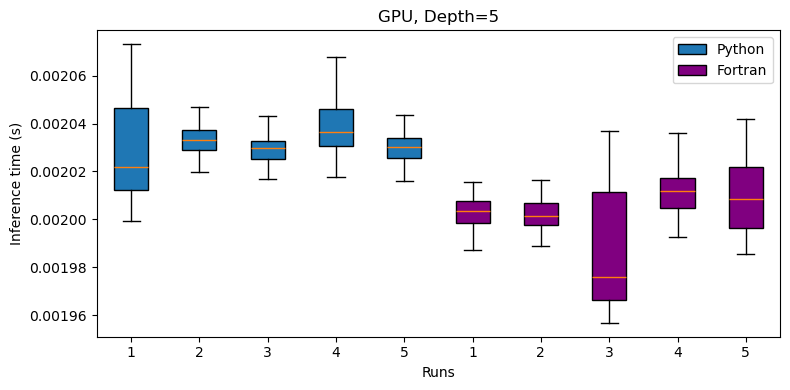

In [64]:
fig, ax = plt.subplots(figsize=(8,4))

runs_n = [1,2,3,4,5,1,2,3,4,5]

bplot = ax.boxplot(np.hstack([pd5g.T, fd5g.T]), patch_artist=True, showfliers=False,
                  tick_labels=runs_n)
for patch in bplot['boxes'][5:]:
    patch.set_facecolor('purple')

ax.legend([bplot['boxes'][0], bplot['boxes'][5]], ['Python', 'Fortran'])

ax.set_ylabel('Inference time (s)')
ax.set_xlabel('Runs')
ax.set_title('GPU, Depth=5')
plt.tight_layout()
plt.savefig("./plots/GPUd5.png")
plt.show()

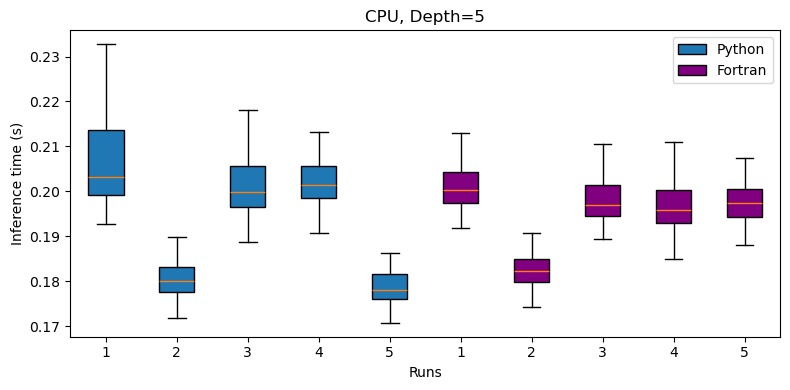

In [63]:
fig, ax = plt.subplots(figsize=(8,4))

runs_n = [1,2,3,4,5,1,2,3,4,5]

bplot = ax.boxplot(np.hstack([pd5c.T, fd5c.T]), patch_artist=True, showfliers=False,
                  tick_labels=runs_n)
for patch in bplot['boxes'][5:]:
    patch.set_facecolor('purple')

ax.legend([bplot['boxes'][0], bplot['boxes'][5]], ['Python', 'Fortran'])

ax.set_ylabel('Inference time (s)')
ax.set_xlabel('Runs')
ax.set_title('CPU, Depth=5')
plt.tight_layout()
plt.savefig("./plots/CPUd5.png")
plt.show()

In [4]:
p_data_loading_g = [0.001943, 0.001323, 0.001201, 0.001141, 0.001285]
p_data_loading_c = [0.001605, 0.001257, 0.001071, 0.001104, 0.001147]
f_data_loading_g = [2.49351398E-03, 2.37146998E-03, 2.41182093E-03, 2.43390095E-03, 2.44986801E-03]
f_data_loading_c = [1.17266399E-03, 1.22165401E-03, 1.18248700E-03, 1.32763397E-03, 1.27995596E-03]

In [30]:
data_loading_all = np.concat([p_data_loading_g, f_data_loading_g, p_data_loading_c, f_data_loading_c])
data_loading_all = np.insert(data_loading_all, 10, 0)
data_loading_all

array([0.001943  , 0.001323  , 0.001201  , 0.001141  , 0.001285  ,
       0.00249351, 0.00237147, 0.00241182, 0.0024339 , 0.00244987,
       0.        , 0.001605  , 0.001257  , 0.001071  , 0.001104  ,
       0.001147  , 0.00117266, 0.00122165, 0.00118249, 0.00132763,
       0.00127996])

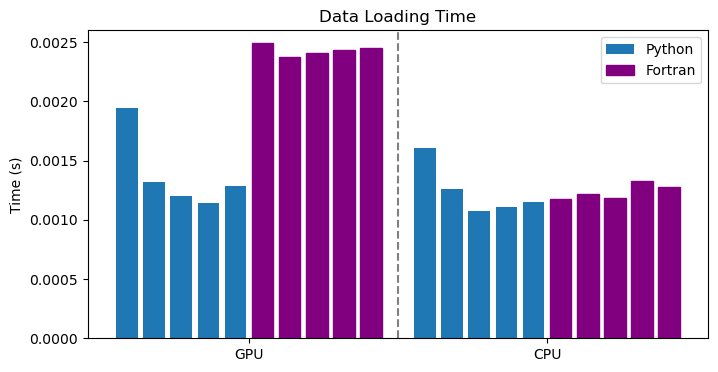

In [58]:
fig, ax = plt.subplots(figsize=(8,4))

#for mode in [p_data_loading_g, f_data_loading_g, p_data_loading_c, f_data_loading_c]:
#    ax.bar([1,2,3,4,5],mode)

barplot = ax.bar(np.arange(21), data_loading_all)
for i in np.concat([np.arange(5,10),np.arange(16,21)]):
    barplot[i].set_color('purple')

ax.legend([barplot[0],barplot[5]],['Python','Fortran'])
ax.set_xticks([4.5,15.5],['GPU','CPU'])
ax.vlines(10,0,1,color='gray',ls='--')
ax.set_ylim(0,0.0026)
ax.set_ylabel('Time (s)')
ax.set_title('Data Loading Time')

plt.savefig('./plots/data_time.png')
plt.show()

In [37]:
p_model_loading_g = [0.036876, 0.035479, 0.033210, 0.033025, 0.032917]
p_model_loading_c = [0.034441, 0.033588, 0.034646, 0.034642, 0.034046]
f_model_loading_g = [5.73777407E-02, 5.76023087E-02, 5.67408316E-02, 5.69072589E-02, 5.61978109E-02]
f_model_loading_c = [0.161052316, 0.185645968, 0.150218263, 6.94343820E-02, 0.125812888]

In [38]:
model_loading_all = np.concat([p_model_loading_g, f_model_loading_g, p_model_loading_c, f_model_loading_c])
model_loading_all = np.insert(model_loading_all, 10, 0)
model_loading_all

array([0.036876  , 0.035479  , 0.03321   , 0.033025  , 0.032917  ,
       0.05737774, 0.05760231, 0.05674083, 0.05690726, 0.05619781,
       0.        , 0.034441  , 0.033588  , 0.034646  , 0.034642  ,
       0.034046  , 0.16105232, 0.18564597, 0.15021826, 0.06943438,
       0.12581289])

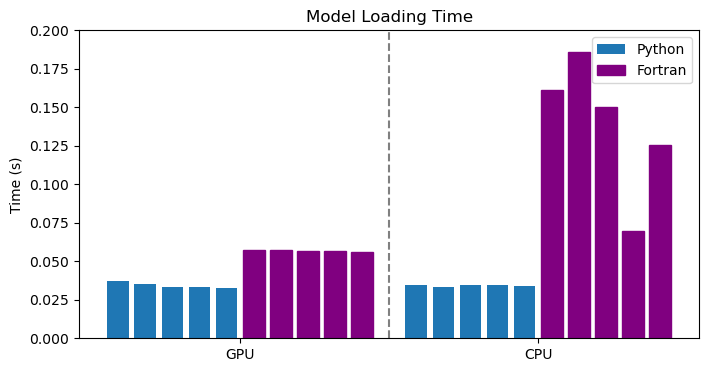

In [59]:
fig, ax = plt.subplots(figsize=(8,4))

#for mode in [p_data_loading_g, f_data_loading_g, p_data_loading_c, f_data_loading_c]:
#    ax.bar([1,2,3,4,5],mode)

barplot = ax.bar(np.arange(21), model_loading_all)
for i in np.concat([np.arange(5,10),np.arange(16,21)]):
    barplot[i].set_color('purple')

ax.legend([barplot[0],barplot[5]],['Python','Fortran'])
ax.set_xticks([4.5,15.5],['GPU','CPU'])
ax.vlines(10,0,1,color='gray',ls='--')
ax.set_ylim(0,0.2)
ax.set_ylabel('Time (s)')
ax.set_title('Model Loading Time')

plt.savefig('./plots/model_time.png')
plt.show()

In [43]:
from scipy.stats import ttest_ind

In [51]:
res = ttest_ind(fd5c, pd5c)
res

TtestResult(statistic=np.float64(0.9736127395476938), pvalue=np.float64(0.3304847768835807), df=np.float64(998.0))